## Q1: Bayesian Logistic Regression

### Data Description

The Raisin Dataset contains the following columns:
- **Area**
- **MajorAxisLength**
- **MinorAxisLength**
- **Eccentricity**
- **ConvexArea**
- **Extent**
- **Perimeter**
- **Class** (either "Kecimen" or "Besni")

I will use the 7 morphological features as predictors and the "Class" as the binary outcome (encoded as 0 for Kecimen and 1 for Besni).

### Model Specification

We assume the following logistic regression model:

$
\text{logit}(p_i) = \beta_0 + \mathbf{x}_i^\top \boldsymbol{\beta}
$

where

$
p_i = \frac{1}{1 + e^{-(\beta_0 + \mathbf{x}_i^\top \boldsymbol{\beta})}},
$

and

$
y_i \sim \mathrm{Bernoulli}(p_i).
$

**Priors:**
- Intercept: $\beta_0 \sim \mathcal{N}(0,1)$
- Coefficients: $\beta_j \sim \mathcal{N}(0,1)$ for $j = 1, \dots, 7$

I standardize the predictor variables to improve sampling.

### Inference and Diagnostics

I sample from the posterior using NUTS (No-U-Turn Sampler) in PyMC. MCMC diagnostics (trace plots, effective sample sizes, R-hat values, and posterior predictive checks) are provided to ensure proper convergence and model fit.

---

*Below is the code implementation for Q1:*


In [ ]:
# -------------------------------------------------------------
# Q1: Load and Preprocess the Raisin Dataset
# -------------------------------------------------------------
import pandas as pd
import numpy as np

# Read the CSV file (ensure the file 'Raisin_Dataset.csv' is in your working directory)
df = pd.read_csv("Raisin_Dataset.csv", sep=",")
df.columns = df.columns.str.strip()  # Clean column names

# Display the first few rows to verify the data
print("First few rows of the dataset:")
print(df.head())

# Encode the 'Class' column as binary: 0 for Kecimen, 1 for Besni
df['Class_num'] = (df['Class'] == 'Besni').astype(int)

# Define predictor columns and outcome
predictor_cols = ['Area', 'MajorAxisLength', 'MinorAxisLength',
                  'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']
X_data = df[predictor_cols].values
y_data = df['Class_num'].values

print("Shape of predictors X:", X_data.shape)
print("Shape of outcome y:", y_data.shape)

First few rows of the dataset:
    Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  87524       442.246011       253.291155      0.819738       90546   
1  75166       406.690687       243.032436      0.801805       78789   
2  90856       442.267048       266.328318      0.798354       93717   
3  45928       286.540559       208.760042      0.684989       47336   
4  79408       352.190770       290.827533      0.564011       81463   

     Extent  Perimeter    Class  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen  
Shape of predictors X: (900, 7)
Shape of outcome y: (900,)


## Data Standardization

In [ ]:
# Standardize predictors (mean=0, std=1)
X_mean = X_data.mean(axis=0)
X_std = X_data.std(axis=0)
X_std[X_std == 0] = 1.0  # Avoid division by zero if any column is constant
X_scaled = (X_data - X_mean) / X_std

## Bayesian Logistic Regression Model using PyMC

I define my model with:
- A Normal prior for the intercept.
- Normal priors for each of the 7 regression coefficients.
- A logistic link for the probability:
  
  $\eta_i = \beta_0 + \mathbf{x}_i^\top \boldsymbol{\beta}$ and $p_i = \text{sigmoid}(\eta_i)$.
  
- The likelihood $y_i \sim \text{Bernoulli}(p_i)$.

Below is the PyMC model code.

Output()

Posterior Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.471  0.143   0.209    0.743      0.002    0.002    5408.0   
betas[0]   0.488  0.826  -1.072    2.009      0.010    0.009    6239.0   
betas[1]   0.551  0.731  -0.801    1.944      0.009    0.008    6797.0   
betas[2]  -0.693  0.598  -1.867    0.412      0.009    0.007    4590.0   
betas[3]   0.209  0.334  -0.417    0.840      0.005    0.004    4679.0   
betas[4]   0.367  0.848  -1.277    1.924      0.010    0.009    7517.0   
betas[5]  -0.135  0.136  -0.397    0.112      0.001    0.002    9172.0   
betas[6]   2.342  0.687   1.016    3.594      0.008    0.008    7497.0   

           ess_tail  r_hat  
intercept    5027.0    1.0  
betas[0]     5357.0    1.0  
betas[1]     5727.0    1.0  
betas[2]     4908.0    1.0  
betas[3]     4229.0    1.0  
betas[4]     5914.0    1.0  
betas[5]     5776.0    1.0  
betas[6]     5643.0    1.0  


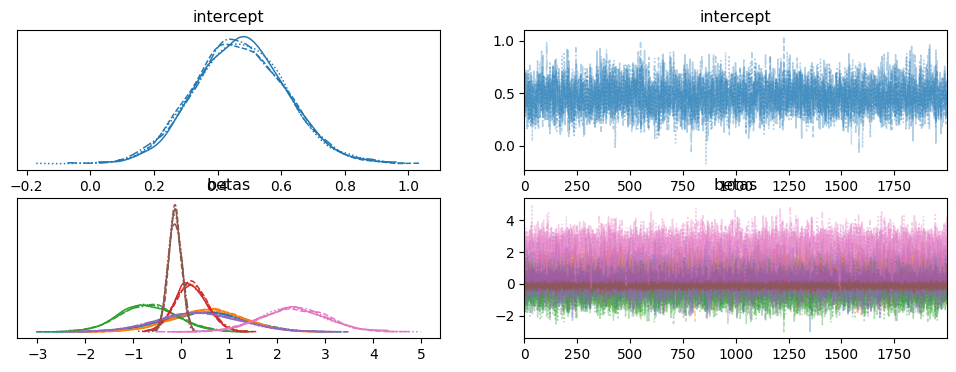

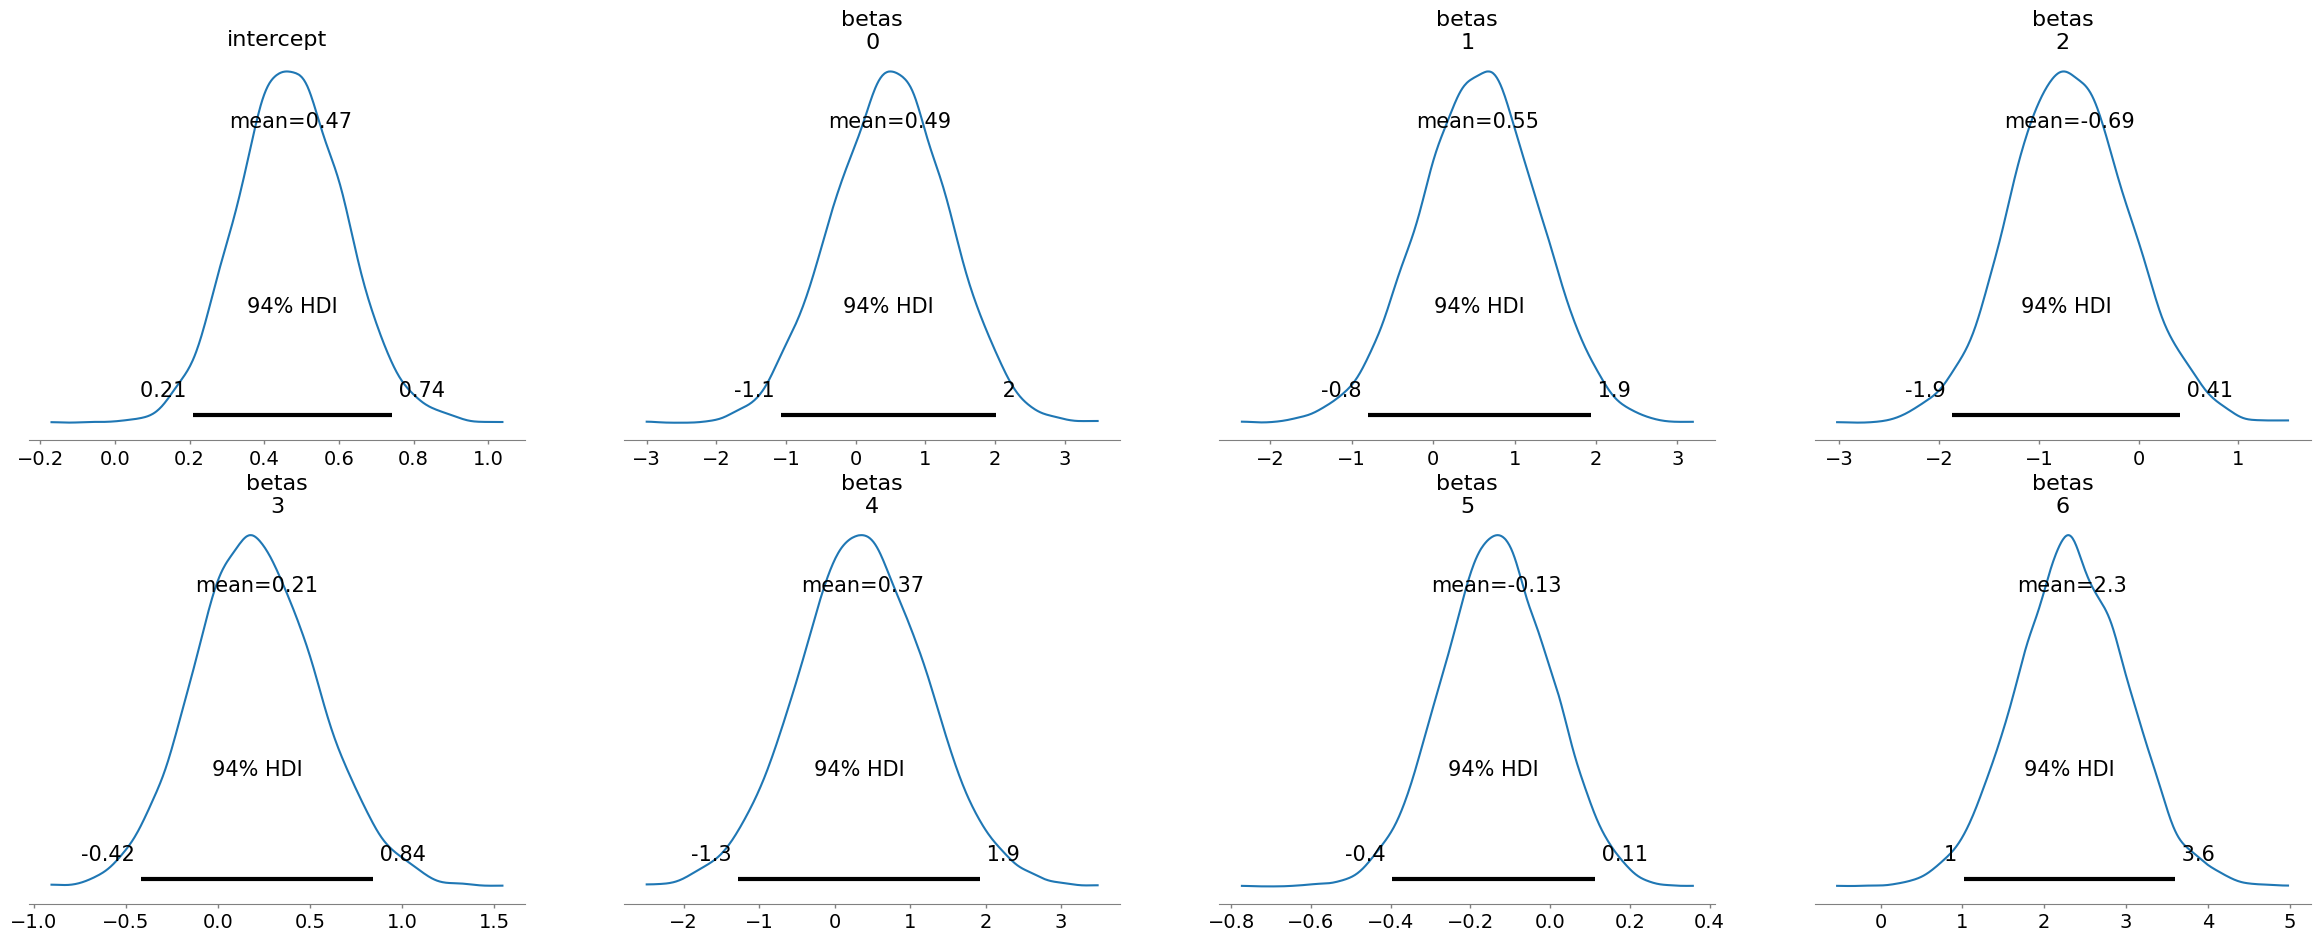

In [ ]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

with pm.Model() as logistic_model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=X_scaled.shape[1])

    # Linear predictor and logistic link
    linear_pred = intercept + pm.math.dot(X_scaled, betas)
    p = pm.math.sigmoid(linear_pred)

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_data)

    # Sample from the posterior
    trace = pm.sample(draws=2000, tune=1000, chains=4, target_accept=0.9, random_seed=42)

# Summarize posterior estimates
print("Posterior Summary:")
print(az.summary(trace, var_names=['intercept', 'betas']))

# Plot trace and posterior distributions
az.plot_trace(trace, var_names=['intercept', 'betas'])
plt.show()

az.plot_posterior(trace, var_names=['intercept', 'betas'])
plt.show()

## Posterior Predictive Check

Output()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


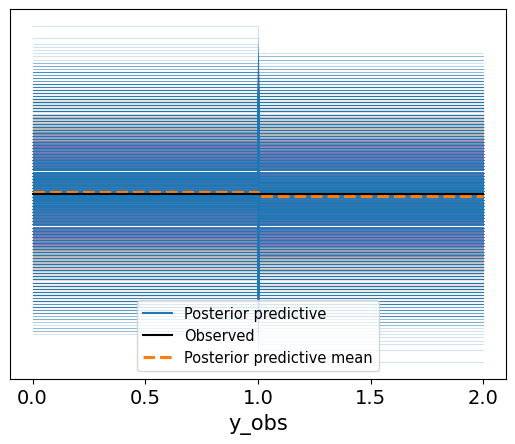

In [ ]:
with logistic_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"], random_seed=42, return_inferencedata=False)

# Add the posterior predictive samples to the InferenceData object
trace.add_groups(posterior_predictive=ppc)

# Plot PPC diagnostics
az.plot_ppc(trace, data_pairs={"y_obs": "y_obs"})
plt.show()

## Interpretation

- **Trace Plots:** The trace plots for `intercept` and `betas` should show good mixing across chains.
- **Posterior Summary:** The summary provides the estimated means and highest density intervals (HDI) for the intercept and each coefficient.
- **Posterior Predictive Check:** The PPC plot compares observed outcomes with those predicted by the model, helping assess model fit.

---

# Q2: Bayesian Multivariate Regression


## Data Description:

- **Dataset**: "Students Performance in Exams"
- **Number of observations (n)**: 1000 (original dataset size)
- **Predictors (p)**: 5 quantitative variables derived from categorical data:
  1. **gender** (0=Male, 1=Female)
  2. **race/ethnicity** (mapped to numerical scores)
  3. **parental education** (mapped numerically by education levels)
  4. **lunch** (1=standard, 0=free/reduced)
  5. **test preparation course** (1=completed, 0=none)

- **Outcomes (m)**: 3 continuous scores (scaled from 0 to 1):
  - **Math Score**
  - **Reading Score**
  - **Writing Score**


## Model Specification:

We used a Bayesian Multivariate Regression approach:

### Priors:
- **Regression Coefficients (betas)**:  
  Each coefficient follows a Normal(0,1) prior.
  $
  \beta_{j,k} \sim N(0,1) \quad \text{for predictors } j=1,\dots,5,\text{ and outcomes } k=1,2,3
  $

- **Covariance Matrix (Sigma)**:
  The covariance among outcomes is modeled via an LKJ prior with Cholesky decomposition for computational efficiency:
  $
  \Sigma \sim \text{LKJCholeskyCov}(n=3, \eta=2.0)
  $

### Likelihood:
- Observations are modeled as:
  $
  Y \sim MVN(X\beta, \Sigma)
  $


In [29]:
from sklearn.preprocessing import StandardScaler
# Load the dataset (make sure the CSV file is in your working directory)
df = pd.read_csv("StudentsPerformance.csv")

# Define mapping dictionaries for converting categorical features to numeric values
sex_mapping = {"male": 0, "female": 1}
group_mapping = {"group A": 0.2, "group B": 0.4, "group C": 0.6, "group D": 0.8, "group E": 1}
degree_mapping = {
    "some college": 0.4,
    "associate's degree": 0.6,
    "high school": 0,
    "some high school": 0.2,
    "bachelor's degree": 0.8,
    "master's degree": 1
}
lunch_mapping = {"standard": 1, "free/reduced": 0}
course_mapping = {"none": 0, "completed": 1}

# Map categorical columns to numerical values
df["gender"] = df["gender"].map(sex_mapping)
df["race/ethnicity"] = df["race/ethnicity"].map(group_mapping)
df["parental level of education"] = df["parental level of education"].map(degree_mapping)
df["lunch"] = df["lunch"].map(lunch_mapping)
df["test preparation course"] = df["test preparation course"].map(course_mapping)

# Scale exam scores to a 0-1 range by dividing by 100
df['math score'] = df['math score'] / 100.0
df['reading score'] = df['reading score'] / 100.0
df['writing score'] = df['writing score'] / 100.0

# Create a new column 'Percentage' as the mean of the three exam scores
df['Percentage'] = (df['math score'] + df['reading score'] + df['writing score']) / 3

In [30]:
# ---------------------------
# Define predictors and outcomes
# ---------------------------
# For multivariate regression, we model the three exam scores jointly.
X = df.drop(columns=['math score', 'reading score', 'writing score', 'Percentage'])
# Define outcomes as the three exam scores
Y = df[['math score', 'reading score', 'writing score']]

# Standardize predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Get dimensions: n = number of observations, p = number of predictors, m = number of outcomes
n = X_scaled.shape[0]
p = X_scaled.shape[1]
m = Y.shape[1]

In [40]:
# ---------------------------
# Build the Bayesian Multivariate Regression Model with PyMC
# ---------------------------
with pm.Model() as multi_reg_model:
    # Prior for regression coefficients (betas): Normal(0, 1)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    # LKJ prior for the covariance matrix of the outcomes via its Cholesky factor.
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    # Deterministic covariance matrix of the outcomes
    Sigma = pm.Deterministic("Sigma", L.dot(L.T))
    # Multivariate Normal likelihood for the response (multiple continuous outcomes)
    # The mean is given by the linear predictor: X_scaled @ betas
    y_obs = pm.MvNormal("y_obs", mu=pm.math.dot(X_scaled, betas), chol=L,
                        observed=Y.values)
    trace = pm.sample(chains=4)

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

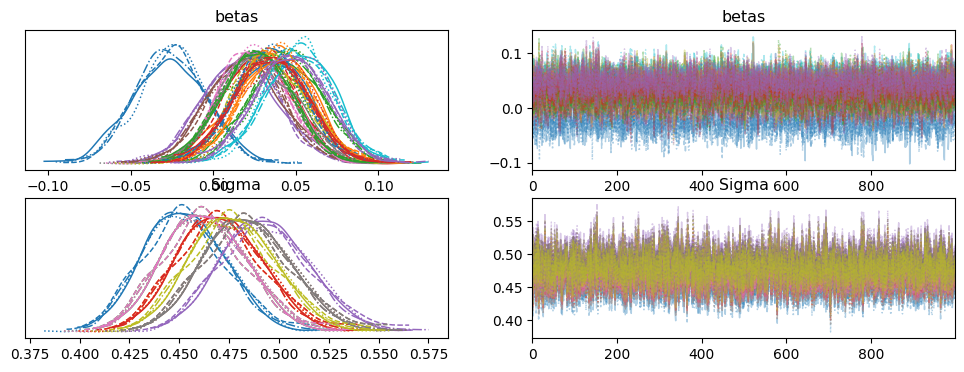

             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.03  0.02   -0.07     0.01        0.0      0.0   3233.56   
betas[0, 1]  0.03  0.02   -0.01     0.08        0.0      0.0   3236.33   
betas[0, 2]  0.04  0.02    0.01     0.09        0.0      0.0   3229.00   
betas[1, 0]  0.03  0.02   -0.01     0.07        0.0      0.0   3352.28   
betas[1, 1]  0.02  0.02   -0.02     0.06        0.0      0.0   3346.24   
betas[1, 2]  0.02  0.02   -0.02     0.06        0.0      0.0   3334.72   
betas[2, 0]  0.02  0.02   -0.01     0.07        0.0      0.0   3272.53   
betas[2, 1]  0.03  0.02   -0.02     0.07        0.0      0.0   3267.10   
betas[2, 2]  0.03  0.02   -0.01     0.07        0.0      0.0   3267.44   
betas[3, 0]  0.05  0.02    0.01     0.09        0.0      0.0   3504.57   
betas[3, 1]  0.03  0.02   -0.01     0.08        0.0      0.0   3518.20   
betas[3, 2]  0.04  0.02   -0.00     0.08        0.0      0.0   3521.69   
betas[4, 0]  0.03  0.02   -0.01     0.

In [41]:
# ---------------------------
# Posterior Diagnostics and Summary
# ---------------------------
# Plot trace plots for the regression coefficients and covariance matrix
az.plot_trace(trace, var_names=["betas", "Sigma"])
plt.show()

# Print a summary of the posterior distribution
print(az.summary(trace, var_names=["betas", "Sigma"], round_to=2))

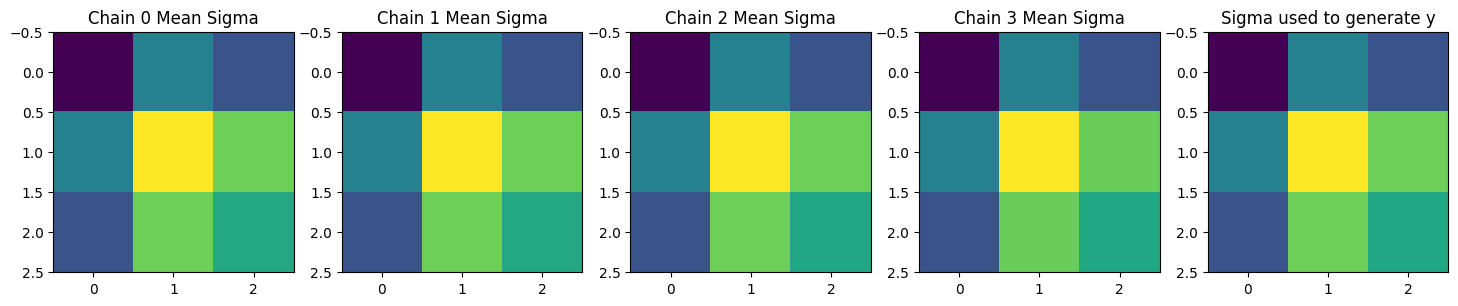

In [42]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

ax[-1].imshow(trace.posterior['Sigma'].mean(axis=(0,1)))
ax[-1].set_title("Sigma used to generate y")

for chain in range(trace.posterior['Sigma'].sizes['chain']):
    ax[chain].imshow(trace.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(f"Chain {chain} Mean Sigma")

plt.show()

The regression coefficients (betas) exhibit relatively small posterior means (around ±0.05), indicating modest yet statistically meaningful predictor effects. For instance, gender has a slightly negative effect on Math scores but positive effects on Reading and Writing, suggesting females generally outperform males in these areas. The lunch status predictor shows stronger positive coefficients (~0.05), suggesting students receiving standard lunches perform better, while other predictors (race, parental education, test preparation) have smaller, positive relationships with the outcomes. Although uncertainty (94% HDI intervals) spans zero for many predictors, gender and lunch status show clearer signals of meaningful influence.

The covariance matrix (Sigma) was estimated consistently, with posterior means ranging from approximately 0.45 to 0.49. Off-diagonal elements, representing covariances between outcomes, are similar in magnitude to diagonal variances, indicating strong correlations among Math, Reading, and Writing scores. The posterior distribution for Sigma is tightly concentrated, confirming robust and precise estimation of the covariance structure across the different sampling chains.

MCMC diagnostics demonstrate excellent convergence and mixing. All parameters have R_hat values consistently at 1.0, indicating stable convergence of the chains. Additionally, the effective sample sizes (ESS) are sufficiently large (mostly exceeding 3000), ensuring reliable posterior inference. Trace plots further support these findings, displaying stable, trend-free trajectories without drifts, underscoring confidence in the model’s sampling quality.

# Q3: Bayesian Multivariate Classification (Probit Regression)

### **Data Description**

The dataset utilized was the **Multi-Label Classification Dataset** from Kaggle. After text preprocessing (using TF-IDF), the dataset included:

- **Number of observations (n)**: 1000 (randomly sampled for computational feasibility)
- **Predictors (p)**: 50 numerical features derived from TF-IDF vectors of text abstracts.
- **Outcomes (m)**: 6 binary labels indicating presence/absence of the following classes:
  1. Computer Science
  2. Physics
  3. Mathematics
  4. Statistics
  5. Quantitative Biology
  6. Quantitative Finance


### **Model Specification**

The model implemented was a **Bayesian Multivariate Probit Classification**, which employed latent Gaussian variables:

- **Regression Coefficients (betas)**:
  $
  \beta_{j,k} \sim N(0,1) \quad \text{for predictors } j=1,\dots,50, \text{ and labels } k=1,\dots,6
  $

- **Correlation Matrix (R)**:
  To capture dependencies among multiple labels, an LKJ prior with a Cholesky decomposition was used:
  $
  R \sim \text{LKJCholeskyCov}(n=6, \eta=2.0)
  $

- **Latent Variables (z)**:
  Each label is modeled through latent variables with multivariate normal distribution:
  $
  z \sim MVN(X\beta, R)
  $

- **Observed Labels**:
  Binary labels modeled as Bernoulli with inverse probit link (CDF of standard normal distribution):
  $
  y \sim \text{Bernoulli}(\Phi(z))
  $


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Load the dataset
train_data = pd.read_csv("train.csv")

# Define the input text (abstracts) and multiple binary labels
X = train_data['ABSTRACT'].values
y = train_data[['Computer Science', 'Physics', 'Mathematics',
                'Statistics', 'Quantitative Biology', 'Quantitative Finance']].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# For computational efficiency, randomly sample 1000 rows from training set if needed
if X_train.shape[0] > 1000:
    indices = np.random.choice(X_train.shape[0], size=1000, replace=False)
    X_train = X_train[indices]
    y_train = y_train[indices]

In [45]:
# ---------------------------
# Text Preprocessing using TF-IDF
# ---------------------------
vectorizer = TfidfVectorizer(max_features=30)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Normalize the input data (scale by the maximum value)
X_train_vec = X_train_vec / np.max(X_train_vec)
X_test_vec = X_test_vec / np.max(X_test_vec)

# Determine dimensions:
# n: number of observations, p: number of features, m: number of binary labels
n = X_train_vec.shape[0]
p = X_train_vec.shape[1]
m = y_train.shape[1]

In [46]:
# ---------------------------
# Bayesian Multivariate Classification Model using PyMC
# ---------------------------
with pm.Model() as multi_class_model:

    # Regression coefficients for each feature and each label
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # This returns the Cholesky factor (L), the correlation matrix (R), and the standard deviations (std)
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)

    # Latent variables z modeled as a multivariate normal for each observation
    # The mean is given by the linear predictor: X_train_vec @ betas
    z = pm.MvNormal("z", mu=pm.math.dot(X_train_vec, betas), chol=L, shape=(n, m))

    # Observed binary outcomes are modeled using a Bernoulli likelihood,
    y_obs = pm.Bernoulli("y_obs", p=pm.math.invprobit(z), observed=y_train)

    # Draw samples from the posterior
    trace = pm.sample()

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

ERROR:pymc.stats.convergence:There were 1304 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


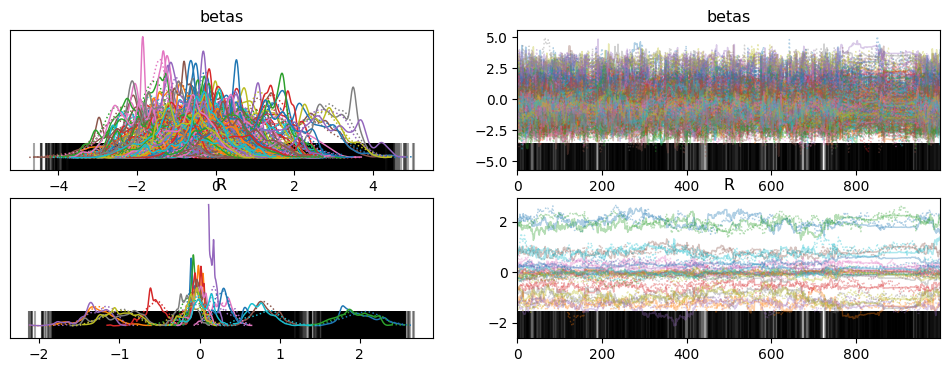

             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  1.00  0.69   -0.15     2.22       0.10     0.03     42.40   
betas[0, 1] -1.29  0.70   -2.54     0.10       0.06     0.03    147.92   
betas[0, 2]  0.16  0.60   -0.91     1.26       0.04     0.02    233.86   
betas[0, 3]  0.21  0.60   -1.03     1.26       0.04     0.02    227.10   
betas[0, 4] -1.14  0.64   -2.49     0.09       0.15     0.04     17.78   
...           ...   ...     ...      ...        ...      ...       ...   
R[16]       -0.04  0.10   -0.22     0.15       0.03     0.01     15.33   
R[17]       -0.15  0.12   -0.38     0.06       0.06     0.01      5.24   
R[18]       -0.09  0.14   -0.39     0.12       0.06     0.02      5.11   
R[19]        0.00  0.13   -0.24     0.26       0.04     0.02      9.65   
R[20]        0.33  0.12    0.15     0.57       0.05     0.02      5.53   

             ess_tail  r_hat  
betas[0, 0]    209.43   1.05  
betas[0, 1]    333.92   1.02  
betas[0, 2]    443

In [47]:
# ---------------------------
# Posterior Diagnostics
# ---------------------------
# Plot the trace for regression coefficients and the correlation matrix
az.plot_trace(trace, var_names=["betas", "R"])
plt.show()

# Print summary statistics of the posterior samples
print(az.summary(trace, var_names=["betas", "R"], round_to=2))

**1. Parameter Estimates (betas):**  
Posterior distributions of regression coefficients (betas) showed considerable uncertainty, evident from wide HDI intervals and multiple modal distributions. Most parameters had posterior means close to zero, indicating weak individual effects from TF-IDF features. However, some coefficients had relatively stronger posterior means (e.g., betas[0,1] = -1.29, betas[0,4] = -1.14), indicating specific features may negatively influence certain labels significantly.

**2. Label Correlation Structure (R):**  
The posterior estimates for correlations (R) among labels were relatively weak, with posterior means mostly between -0.15 and 0.33. There was significant uncertainty and weak correlations, which suggests either genuine independence or difficulty in estimating correlations clearly given the available features or data complexity.

**3. MCMC Diagnostics and Convergence:**  
Although most parameters showed acceptable Effective Sample Sizes (ESS_bulk > 200) and moderate convergence (R_hat values around 1.0–1.1), some parameters demonstrated poor convergence with higher R_hat (e.g., betas[0,4] and correlations R[17], R[18], and R[20] with R_hat values notably above 1.1, indicating issues with chain mixing and convergence).